# German Traffic Signs

## Overview

German traffic signs are standardized symbols used to regulate, warn, or guide drivers and pedestrians. They are essential for road safety and traffic management. Signs are divided into categories based on their function.

## Categories

| Category     | Description |
|-------------|-------------|
| Regulatory   | Rules that must be followed (e.g., Stop, Yield, Speed Limits) |
| Warning      | Alert to hazards or changes (e.g., Sharp Curve, Pedestrian Crossing, Roadworks) |
| Informational | Guidance or facilities (e.g., Highway, Parking, Hospital) |
| Priority     | Indicate right of way (e.g., Main Road, End of Priority Road) |
| Prohibitory  | Forbidden actions (e.g., No Entry, No Parking, No Overtaking) |

## German Traffic Sign Recognition Benchmark (GTSRB)

- Dataset widely used for computer vision and machine learning.  
- Contains **images of 43 traffic sign classes**.  
- Images vary in size, lighting, and viewpoint, reflecting real-world conditions.  
- Commonly used for **multiclass classification tasks** in AI projects.  

## List of 43 Classes

# German Traffic Sign Classes (3 Columns)

| ID  | Sign Name                  | ID  | Sign Name                 | ID  | Sign Name                 |
|-----|----------------------------|-----|---------------------------|-----|---------------------------|
| 0   | Speed Limit 20 km/h        | 15  | No Vehicles               | 30  | Cyclists                  |
| 1   | Speed Limit 30 km/h        | 16  | Vehicles > 3.5t Prohibited| 31  | Snow/Ice                  |
| 2   | Speed Limit 50 km/h        | 17  | No Entry                  | 32  | Wild Animals              |
| 3   | Speed Limit 60 km/h        | 18  | General Caution           | 33  | End of All Restrictions   |
| 4   | Speed Limit 70 km/h        | 19  | Dangerous Curve Left      | 34  | Turn Right Ahead          |
| 5   | Speed Limit 80 km/h        | 20  | Dangerous Curve Right     | 35  | Turn Left Ahead           |
| 6   | End of Speed Limit 80 km/h | 21  | Double Curve              | 36  | Ahead Only                |
| 7   | Speed Limit 100 km/h       | 22  | Bumpy Road                | 37  | Go Straight or Right      |
| 8   | Speed Limit 120 km/h       | 23  | Slippery Road             | 38  | Go Straight or Left       |
| 9   | No Overtaking              | 24  | Road Narrows Left         | 39  | Keep Right                |
| 10  | No Overtaking for Trucks   | 25  | Road Narrows Right        | 40  | Keep Left                 |
| 11  | Priority Road              | 26  | Road Works                | 41  | Roundabout                |
| 12  | End of Priority Road       | 27  | Traffic Signals           | 42  | End of No Overtaking      |
| 13  | Give Way                   | 28  | Pedestrian Crossing       |     |                           |
| 14  | Stop                       | 29  | Children                  |     |                           

## References

- [GTSRB Dataset on Kaggle](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign)  
- [German Road Traffic Regulations](https://www.gesetze-im-internet.de/stvo_2013/)

### Preliminary Example

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

example = Image.open('/kaggle/input/gtsrb-german-traffic-sign/Train/0/00000_00000_00000.png').convert('RGB')

example_array = np.array(example)

plt.imshow(example_array)
plt.title("Sign Example")
plt.axis("on")
plt.show()

print("Shape:", example_array.shape)
print("Range of values: ", example_array.min(), "a", example_array.max())

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/gtsrb-german-traffic-sign/Train/0/00000_00000_00000.png'

### Loading creating dataset class

In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class GTSRBDataset(Dataset):
    def __init__(self, root_dir, csv_file=None, transform=None, train=True):
        self.train = train
        self.transform = transform
        if train:
            self.samples = []
            for label in range(43):
                dir_path = os.path.join(root_dir, 'Train', str(label))
                for fname in os.listdir(dir_path):
                    self.samples.append((os.path.join(dir_path, fname), label))
        else:
            df = pd.read_csv(csv_file)
            self.samples = [(os.path.join(root_dir, row['Path']), row['ClassId'])
                            for idx, row in df.iterrows()]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

### Creating transforms

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.3212, 0.2969, 0.3051],
                         std=[0.1629, 0.1616, 0.1687])
])

test_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.3212, 0.2969, 0.3051],
                         std=[0.1629, 0.1616, 0.1687])
])

### Loading dataset

In [ ]:
root_dir = "/kaggle/input/gtsrb-german-traffic-sign"
csv_test = os.path.join(root_dir, "Test.csv")

train_dataset = GTSRBDataset(root_dir=root_dir, transform=train_transform, train=True)
test_dataset = GTSRBDataset(root_dir=root_dir, csv_file=csv_test, transform=test_transform, train=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

print("Tamaño train:", len(train_dataset))
print("Tamaño test:", len(test_dataset))

images, labels = next(iter(train_loader))
print("Batch imágenes:", images.shape)
print("Batch etiquetas:", labels.shape)

Tamaño train: 39209
Tamaño test: 12630
Batch imágenes: torch.Size([256, 3, 28, 28])
Batch etiquetas: torch.Size([256])


### EDA

In [ ]:
import warnings

warnings.filterwarnings("ignore")

import torch
from tqdm import tqdm
def compute_mean_std(loader):
    n_images = 0
    mean = 0.0
    std = 0.0

    for images, _ in tqdm(loader):
        batch_samples = images.to(device).size(0)
        images = images.view(batch_samples, images.size(1), -1)

        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        n_images += batch_samples

    mean /= n_images
    std /= n_images
    return mean, std

mean, std = compute_mean_std(train_loader)
print("Mean:", mean)
print("Std:", std)

100%|██████████| 154/154 [01:37<00:00,  1.58it/s]

Mean: tensor([-0.0004, -0.0001,  0.0005])
Std: tensor([0.9999, 0.9992, 0.9993])


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_class_distribution(dataset, title="Class distribution"):
    labels = [label for _, label in tqdm(dataset)]
    counter = Counter(labels)

    classes = sorted(counter.keys())
    counts = [counter[c] for c in classes]

    plt.figure(figsize=(12,6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel("Class")
    plt.ylabel("Quantity of images")
    plt.title(title)
    plt.xticks(classes)
    plt.show()

100%|██████████| 39209/39209 [01:26<00:00, 451.53it/s]


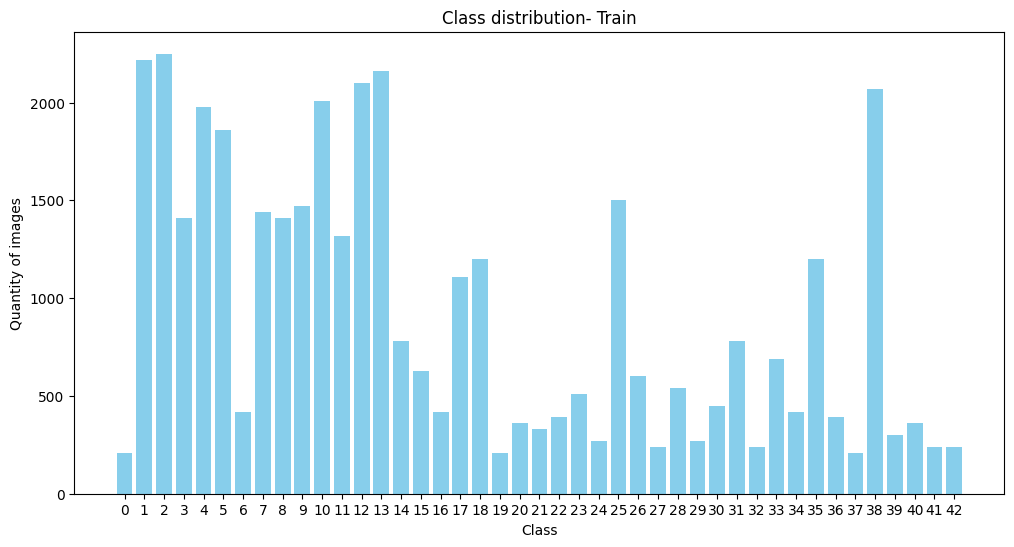

100%|██████████| 12630/12630 [00:30<00:00, 412.84it/s]


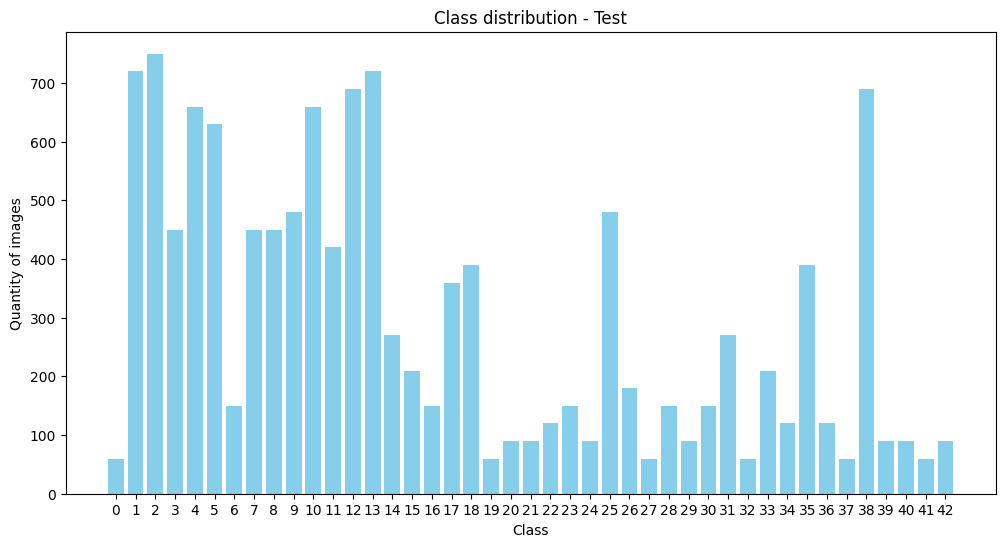

In [ ]:
plot_class_distribution(train_dataset, title="Class distribution- Train")

plot_class_distribution(test_dataset, title="Class distribution - Test")

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

MEAN = torch.tensor([0.3212, 0.2969, 0.3051]).view(3,1,1)
STD  = torch.tensor([0.1629, 0.1616, 0.1687]).view(3,1,1)

def denormalize_image(image_tensor):
    image = image_tensor * STD + MEAN
    image = image.permute(1,2,0).numpy()
    return np.clip(image, 0, 1)

def create_class_index(dataset):
    class_to_indices = defaultdict(list)
    for i, (_, label) in enumerate(tqdm(dataset)):
        class_to_indices[label].append(i)
    return class_to_indices

def show_examples_all_classes(dataset, class_to_indices, n=5):
    num_classes = len(class_to_indices)
    for class_id in sorted(class_to_indices.keys()):
        indices = class_to_indices[class_id]
        chosen_indices = random.sample(indices, min(n, len(indices)))

        plt.figure(figsize=(n*3,3))
        for i, idx in enumerate(chosen_indices):
            image, label = dataset[idx]
            if isinstance(image, torch.Tensor):
                image = denormalize_image(image)

            plt.subplot(1, n, i+1)
            plt.imshow(image)
            plt.title(f"Class {label}")
            plt.axis("off")
        plt.show()

class_to_indices = create_class_index(train_dataset)

100%|██████████| 39209/39209 [01:34<00:00, 413.92it/s]


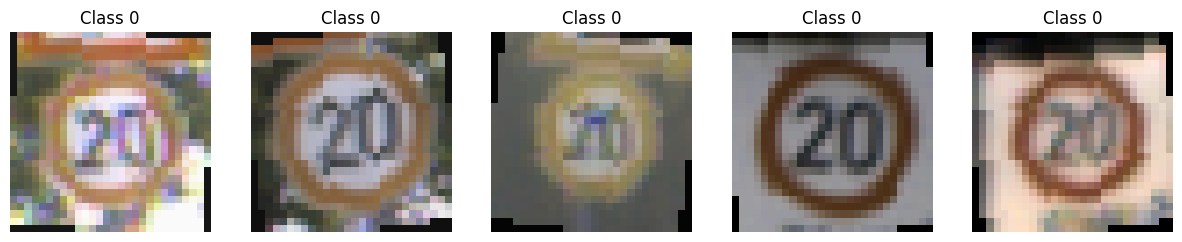

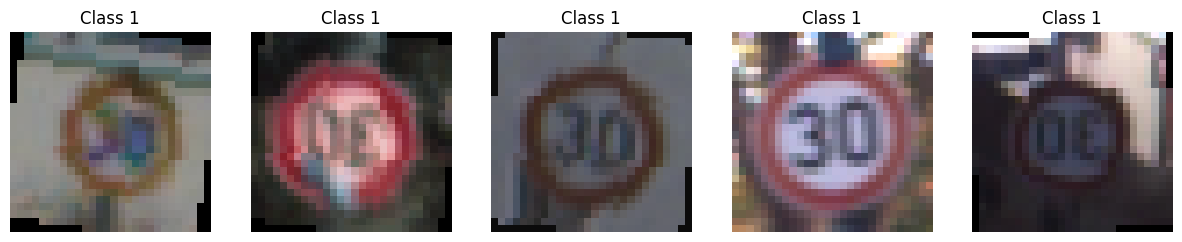

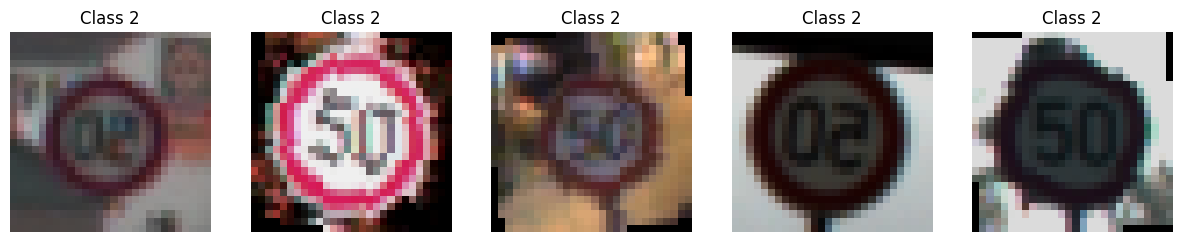

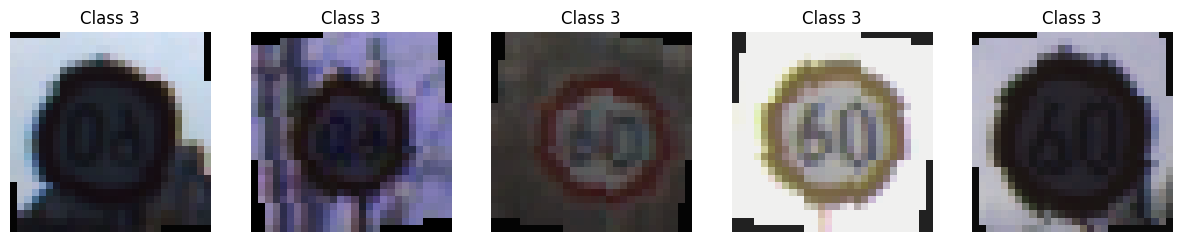

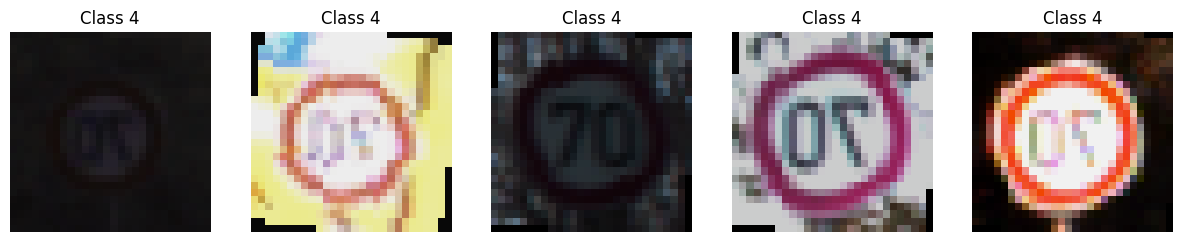

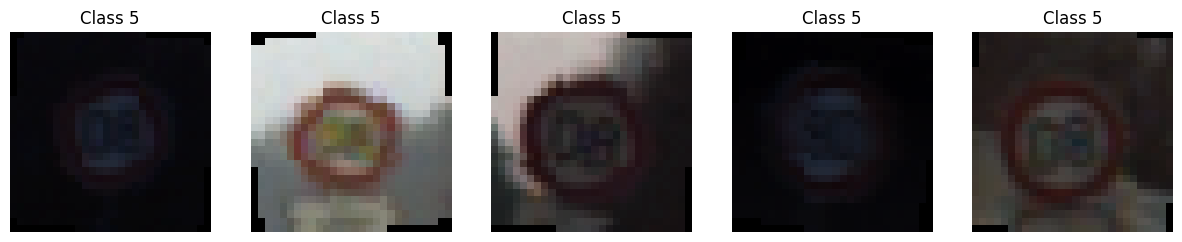

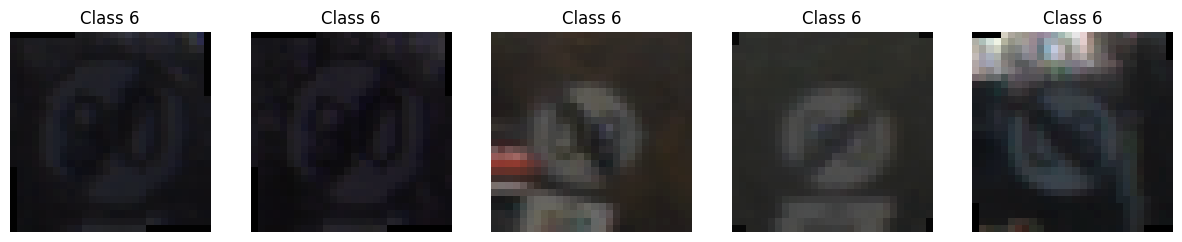

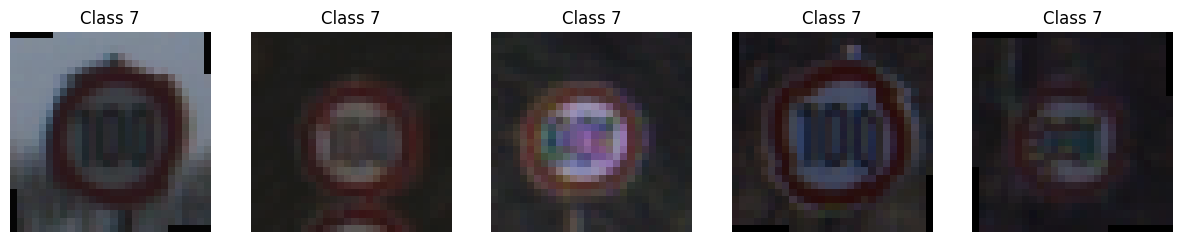

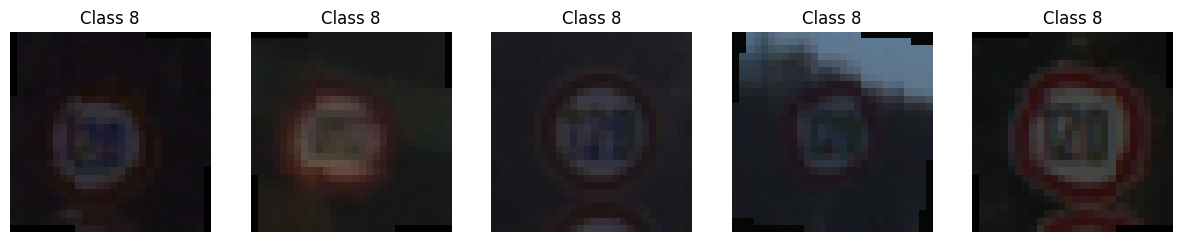

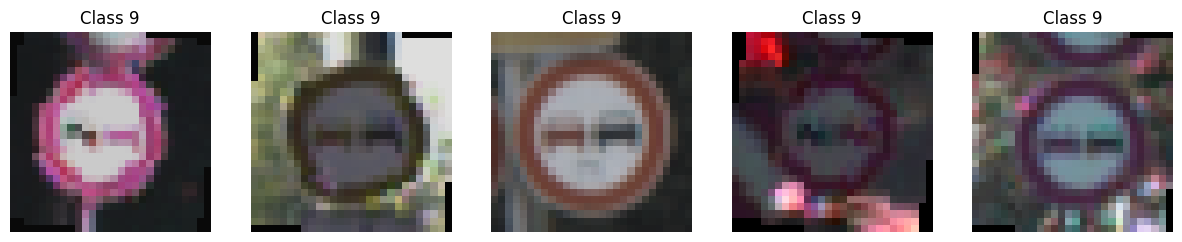

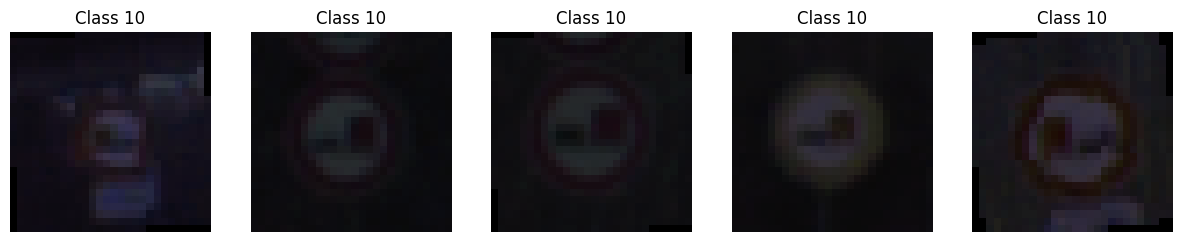

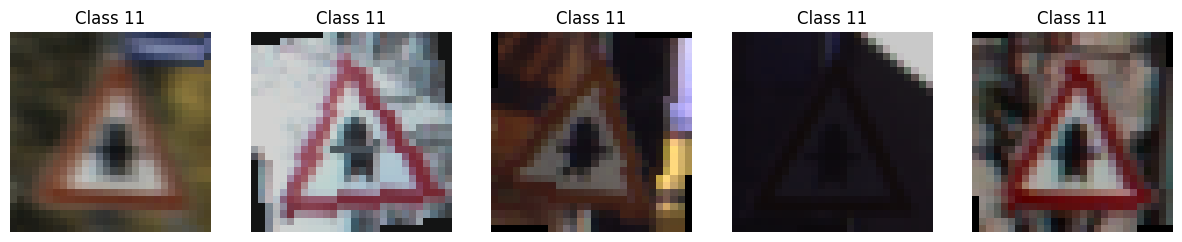

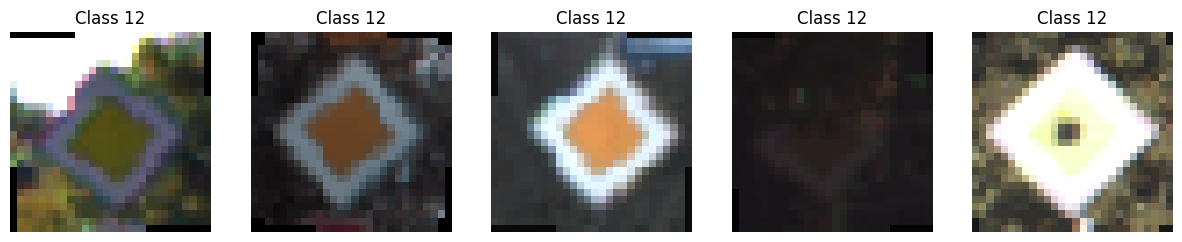

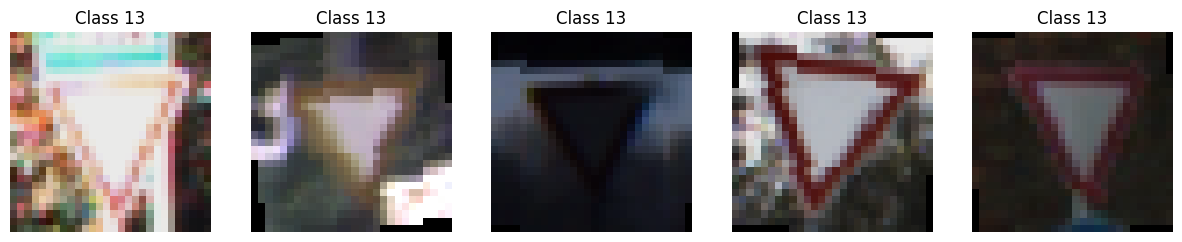

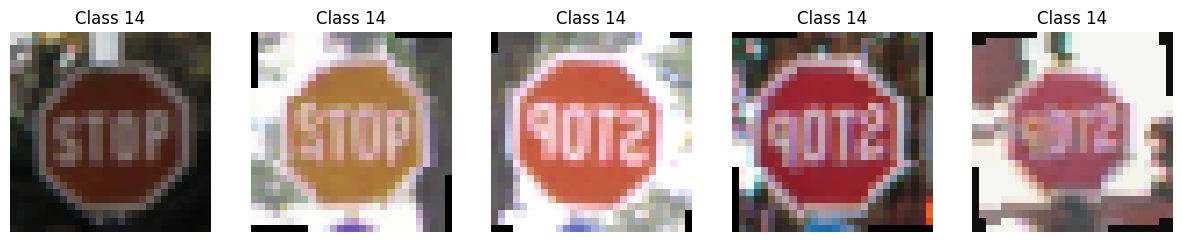

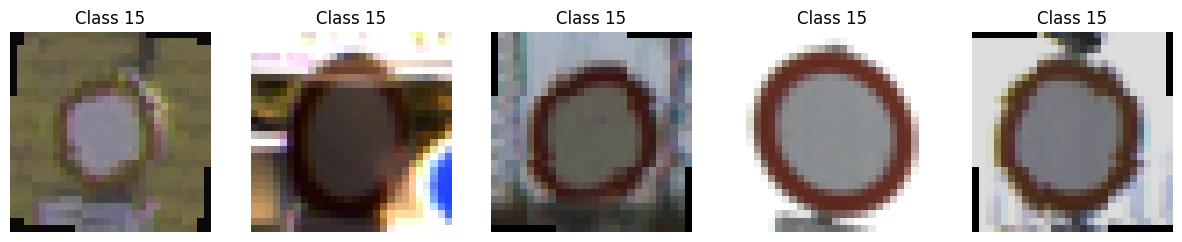

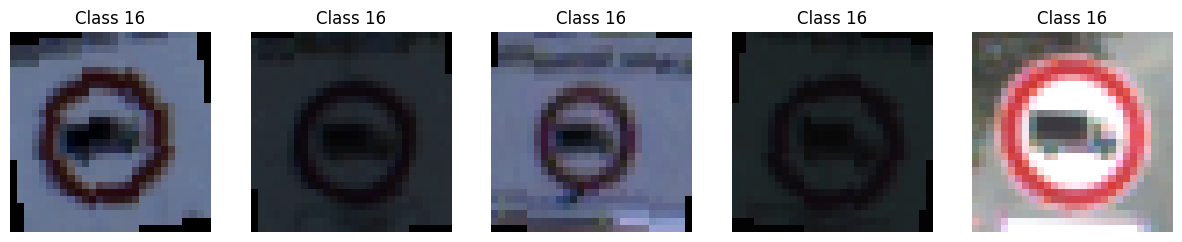

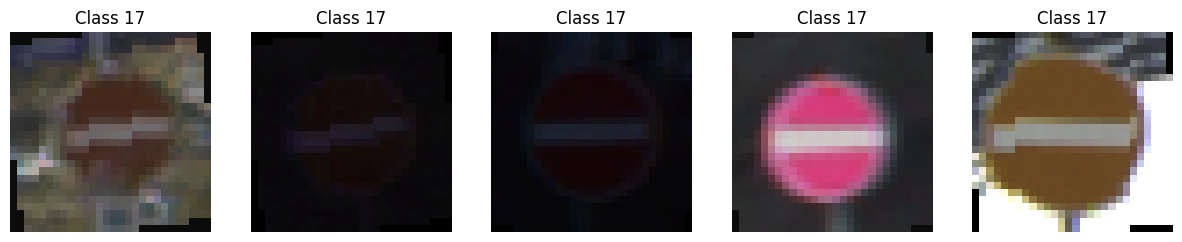

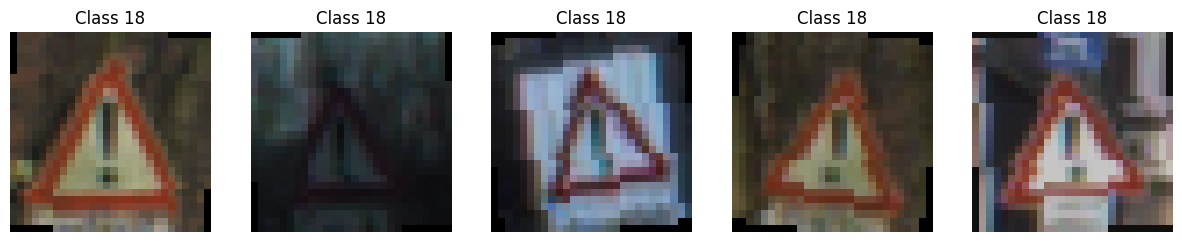

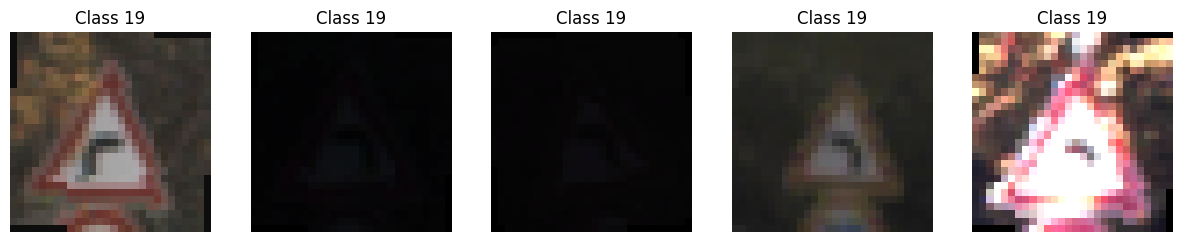

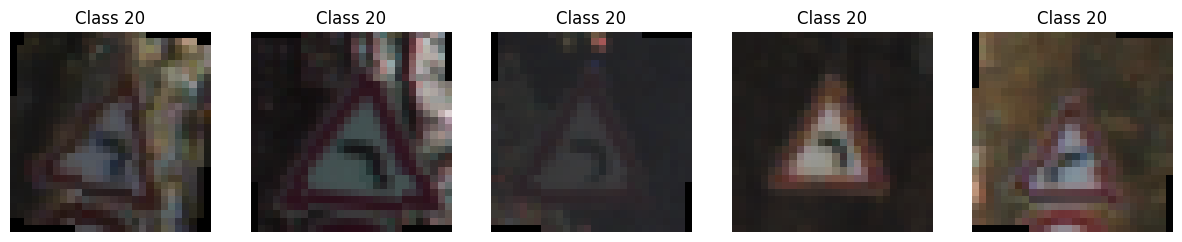

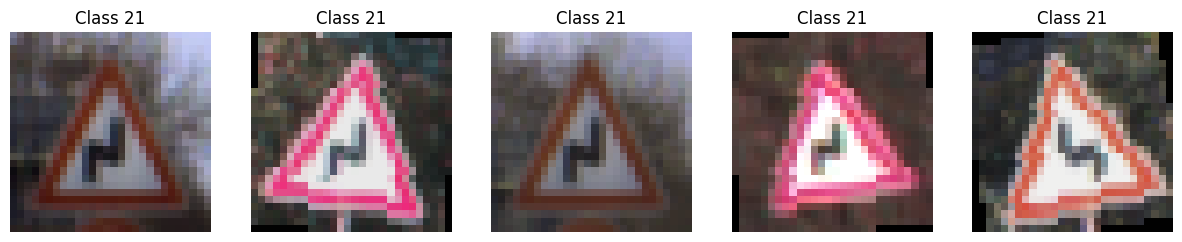

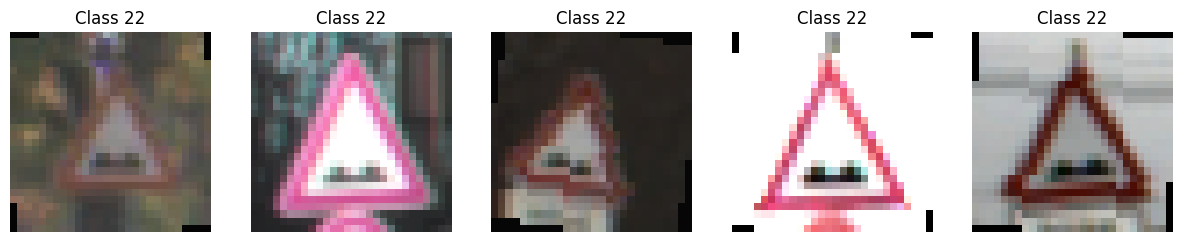

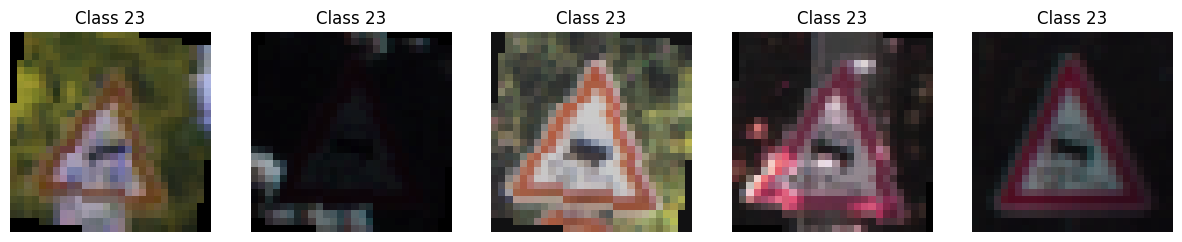

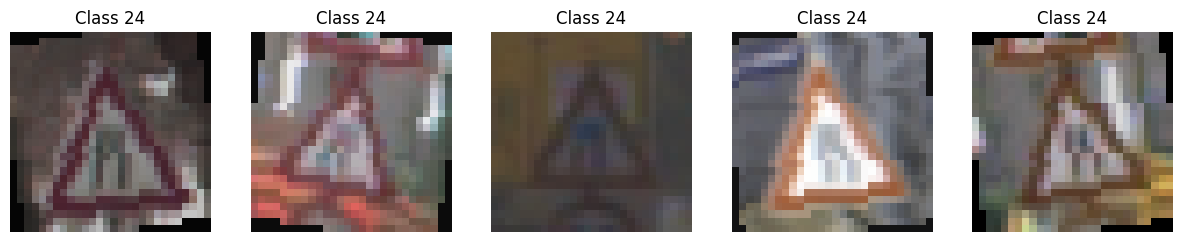

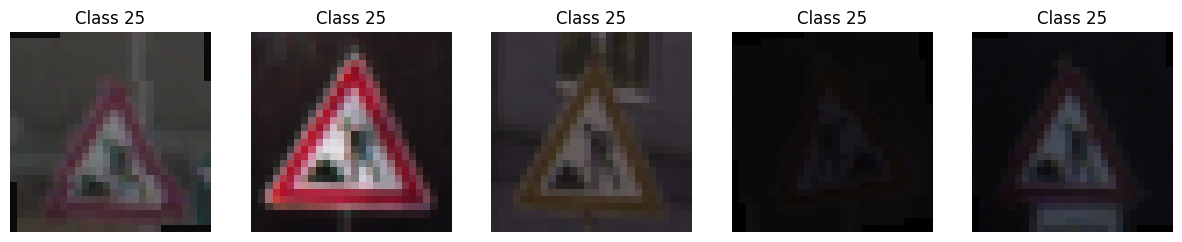

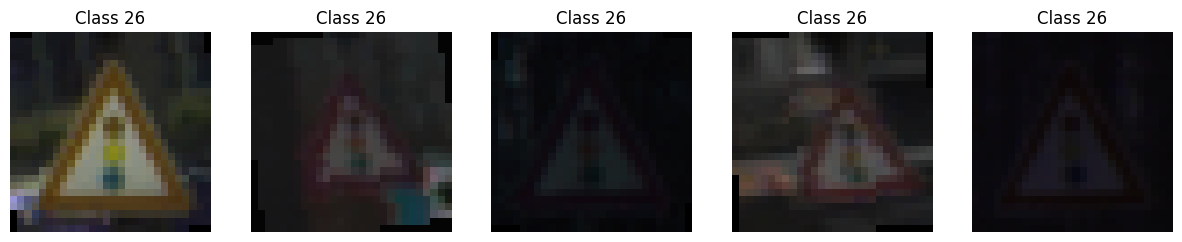

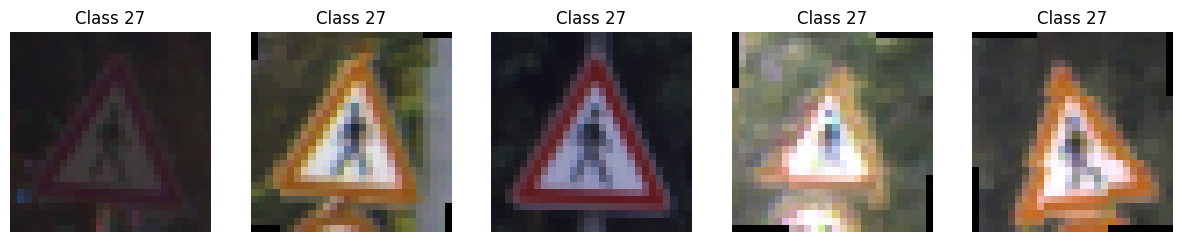

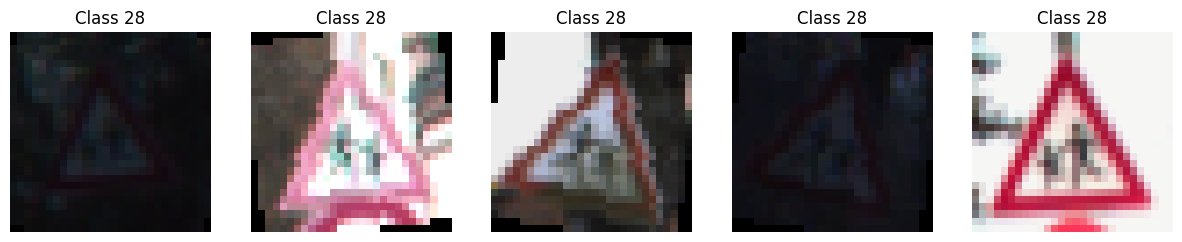

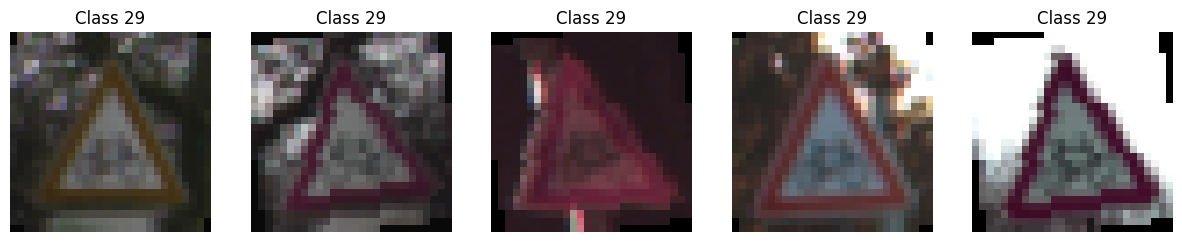

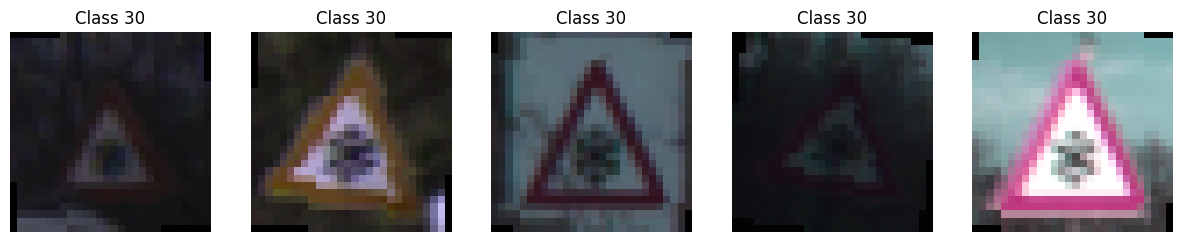

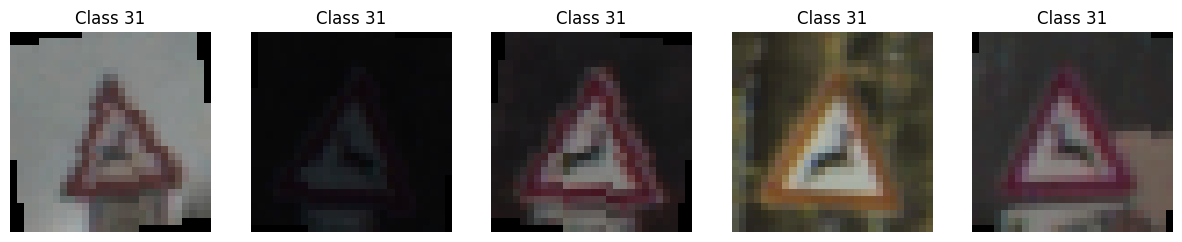

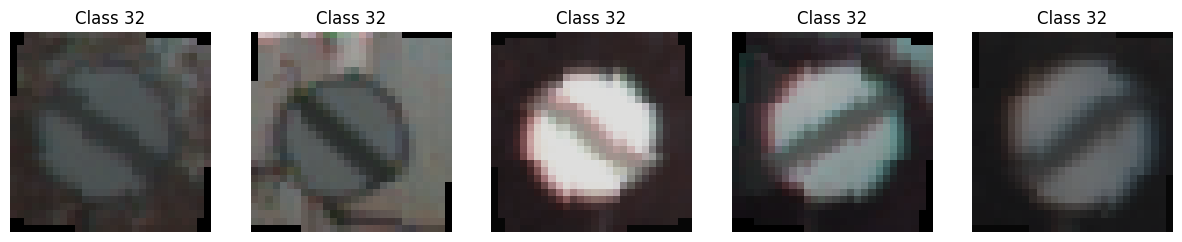

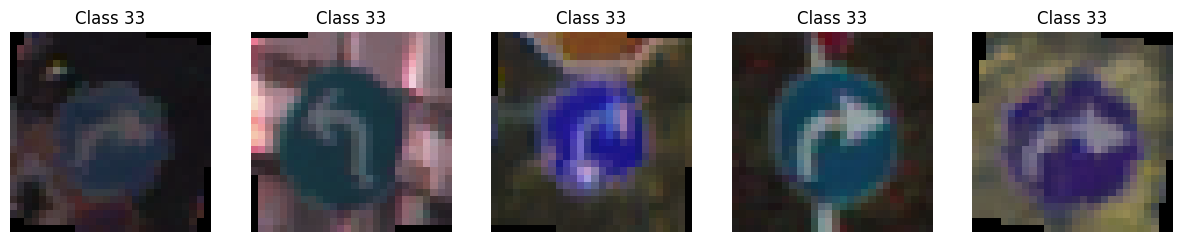

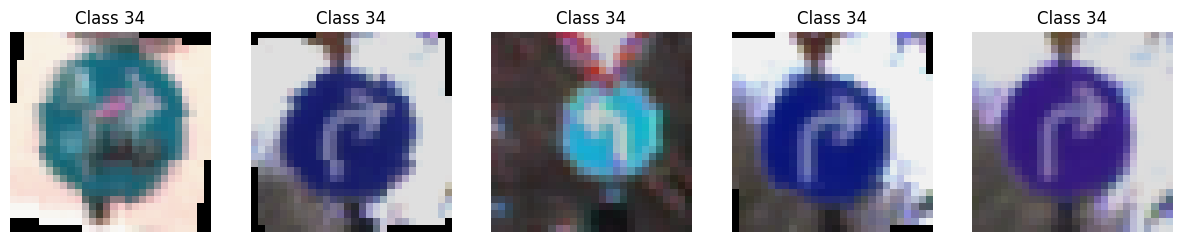

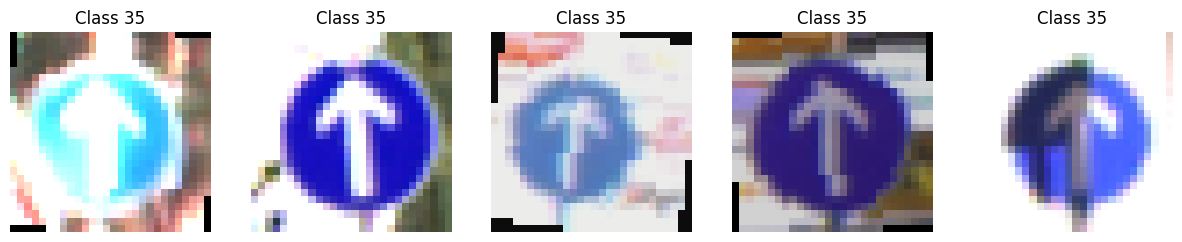

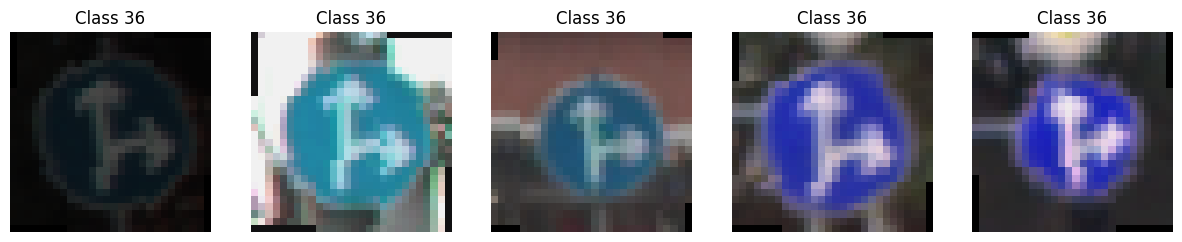

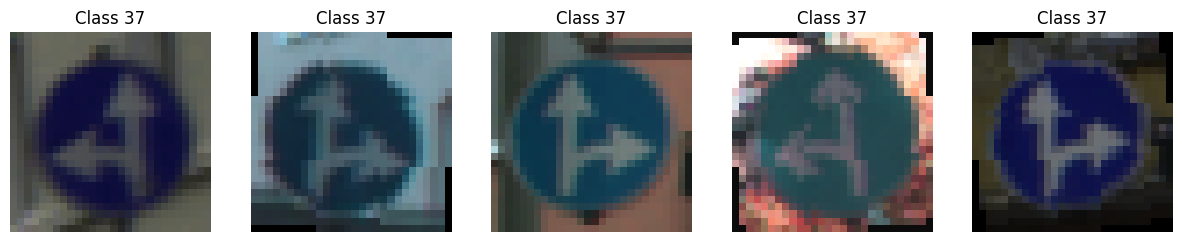

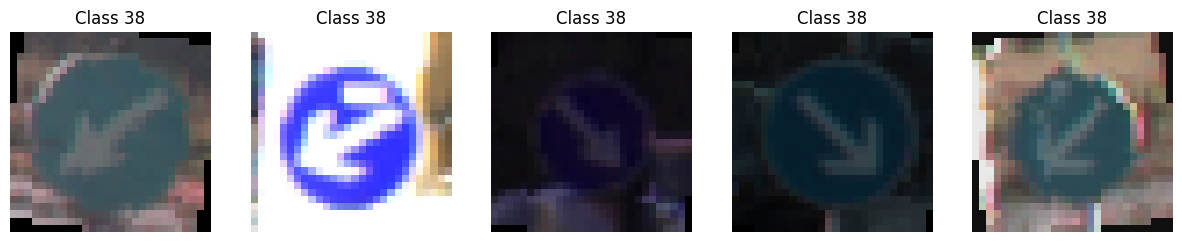

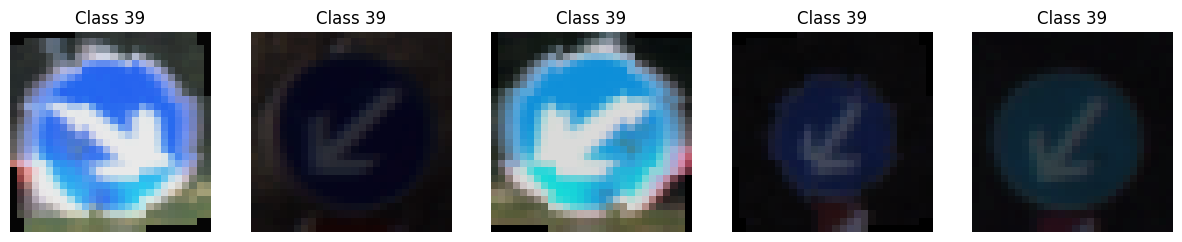

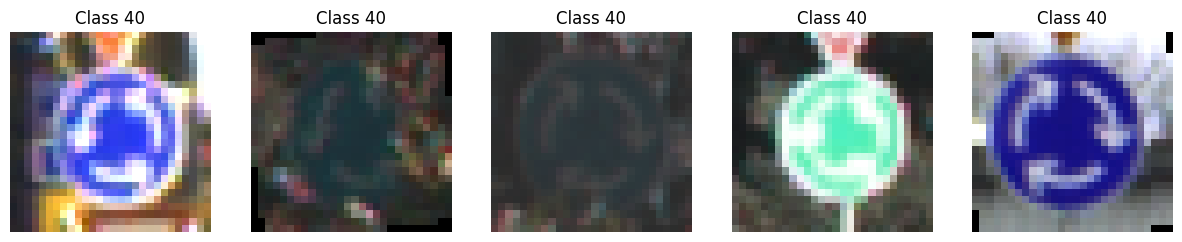

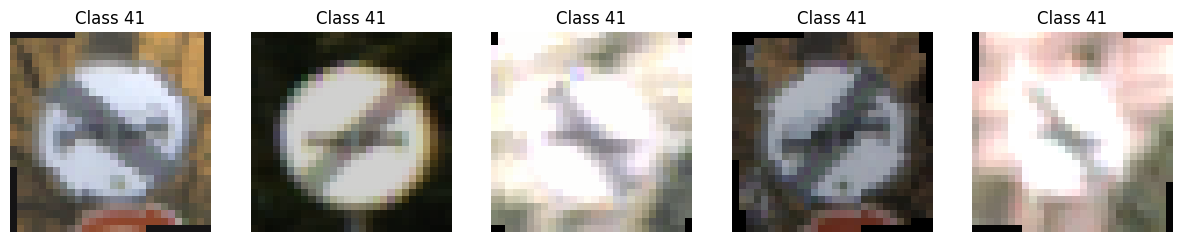

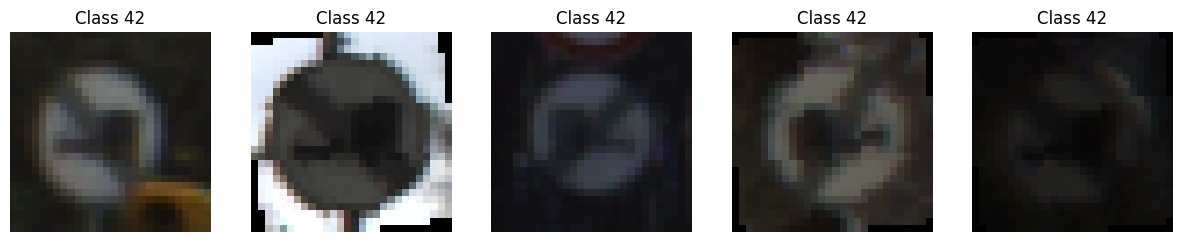

In [ ]:
show_examples_all_classes(train_dataset, class_to_indices, n=5)

# Convolutional Neural Networks (CNN) with Cross-Entropy Loss

## 1. Convolutional Neural Network (CNN)

A **Convolutional Neural Network (CNN)** is a type of deep learning model especially useful for image classification tasks.  
It automatically extracts features (edges, shapes, patterns) through convolutional layers instead of relying on manual feature engineering.  

### Key Components:
- **Convolutional Layers**: Apply filters (kernels) to capture local patterns such as edges or textures.
- **Pooling Layers**: Reduce spatial dimensions while retaining important information (e.g., MaxPooling).
- **Fully Connected Layers**: Combine extracted features to perform classification.
- **Activation Functions**: Non-linear transformations (e.g., ReLU) that introduce learning complexity.
- **Dropout / BatchNorm**: Regularization techniques to prevent overfitting.

---

## 2. Cross-Entropy Loss

For **multiclass classification**, we typically use **Cross-Entropy Loss**.  
It measures the difference between the predicted probability distribution (from softmax) and the true distribution (one-hot encoded labels).

### Formula:

![image.png](attachment:bd4c84b4-4859-4e3b-bd4a-2d355646854d.png)

Where:
- `C` = number of classes  
- `y_k` = true label (1 for correct class, 0 for others)  
- `ŷ_k` = predicted probability for class `k`  

The model learns by minimizing this loss function.




<img src="https://upload.wikimedia.org/wikipedia/commons/9/90/CNN-filter-animation-1.gif">

<img src="https://upload.wikimedia.org/wikipedia/commons/0/04/Convolution_arithmetic_-_Padding_strides.gif">

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes=43):
        super(TrafficSignCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = None
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)

        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), 256).to(x.device)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TrafficSignCNN(num_classes=43).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = running_corrects / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_acc  = val_running_corrects / val_total

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

100%|██████████| 50/50 [00:20<00:00,  2.41it/s]


Epoch 1/10 | Train Loss: 2.7533, Train Acc: 0.2365 | Val Loss: 1.7945, Val Acc: 0.4530


100%|██████████| 50/50 [00:20<00:00,  2.48it/s]


Epoch 2/10 | Train Loss: 1.4345, Train Acc: 0.5440 | Val Loss: 1.1425, Val Acc: 0.6314


100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


Epoch 3/10 | Train Loss: 0.9340, Train Acc: 0.6949 | Val Loss: 0.8852, Val Acc: 0.7168


100%|██████████| 50/50 [00:23<00:00,  2.09it/s]


Epoch 4/10 | Train Loss: 0.6792, Train Acc: 0.7795 | Val Loss: 0.6793, Val Acc: 0.7927


100%|██████████| 50/50 [00:25<00:00,  1.94it/s]


Epoch 5/10 | Train Loss: 0.5290, Train Acc: 0.8299 | Val Loss: 0.5938, Val Acc: 0.8241


100%|██████████| 50/50 [00:37<00:00,  1.34it/s]


Epoch 6/10 | Train Loss: 0.4329, Train Acc: 0.8598 | Val Loss: 0.5564, Val Acc: 0.8409


100%|██████████| 50/50 [00:22<00:00,  2.17it/s]


Epoch 7/10 | Train Loss: 0.3725, Train Acc: 0.8799 | Val Loss: 0.4852, Val Acc: 0.8622


100%|██████████| 50/50 [00:27<00:00,  1.81it/s]


Epoch 8/10 | Train Loss: 0.3211, Train Acc: 0.8973 | Val Loss: 0.4370, Val Acc: 0.8766


100%|██████████| 50/50 [00:20<00:00,  2.43it/s]


Epoch 9/10 | Train Loss: 0.2832, Train Acc: 0.9087 | Val Loss: 0.4312, Val Acc: 0.8778


100%|██████████| 50/50 [00:20<00:00,  2.40it/s]

Epoch 10/10 | Train Loss: 0.2579, Train Acc: 0.9174 | Val Loss: 0.4004, Val Acc: 0.8891


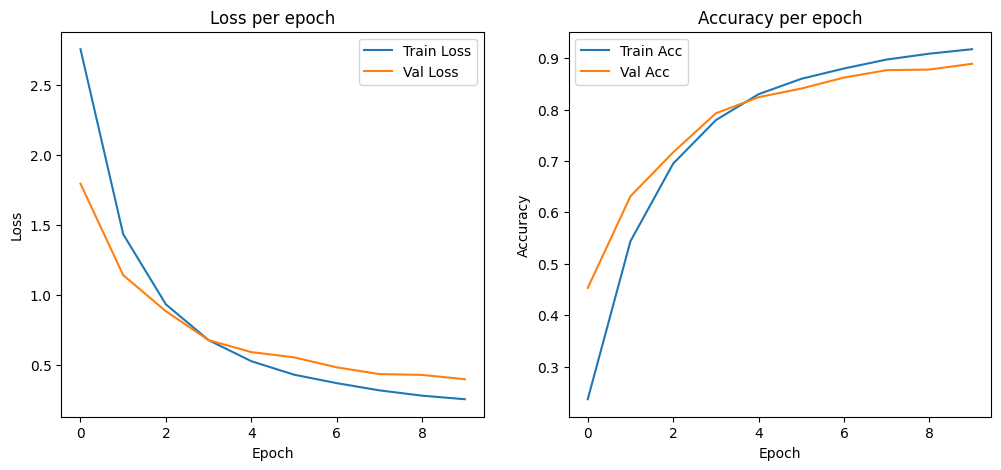

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss per epoch")

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy per epoch")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

100%|██████████| 154/154 [01:27<00:00,  1.76it/s]


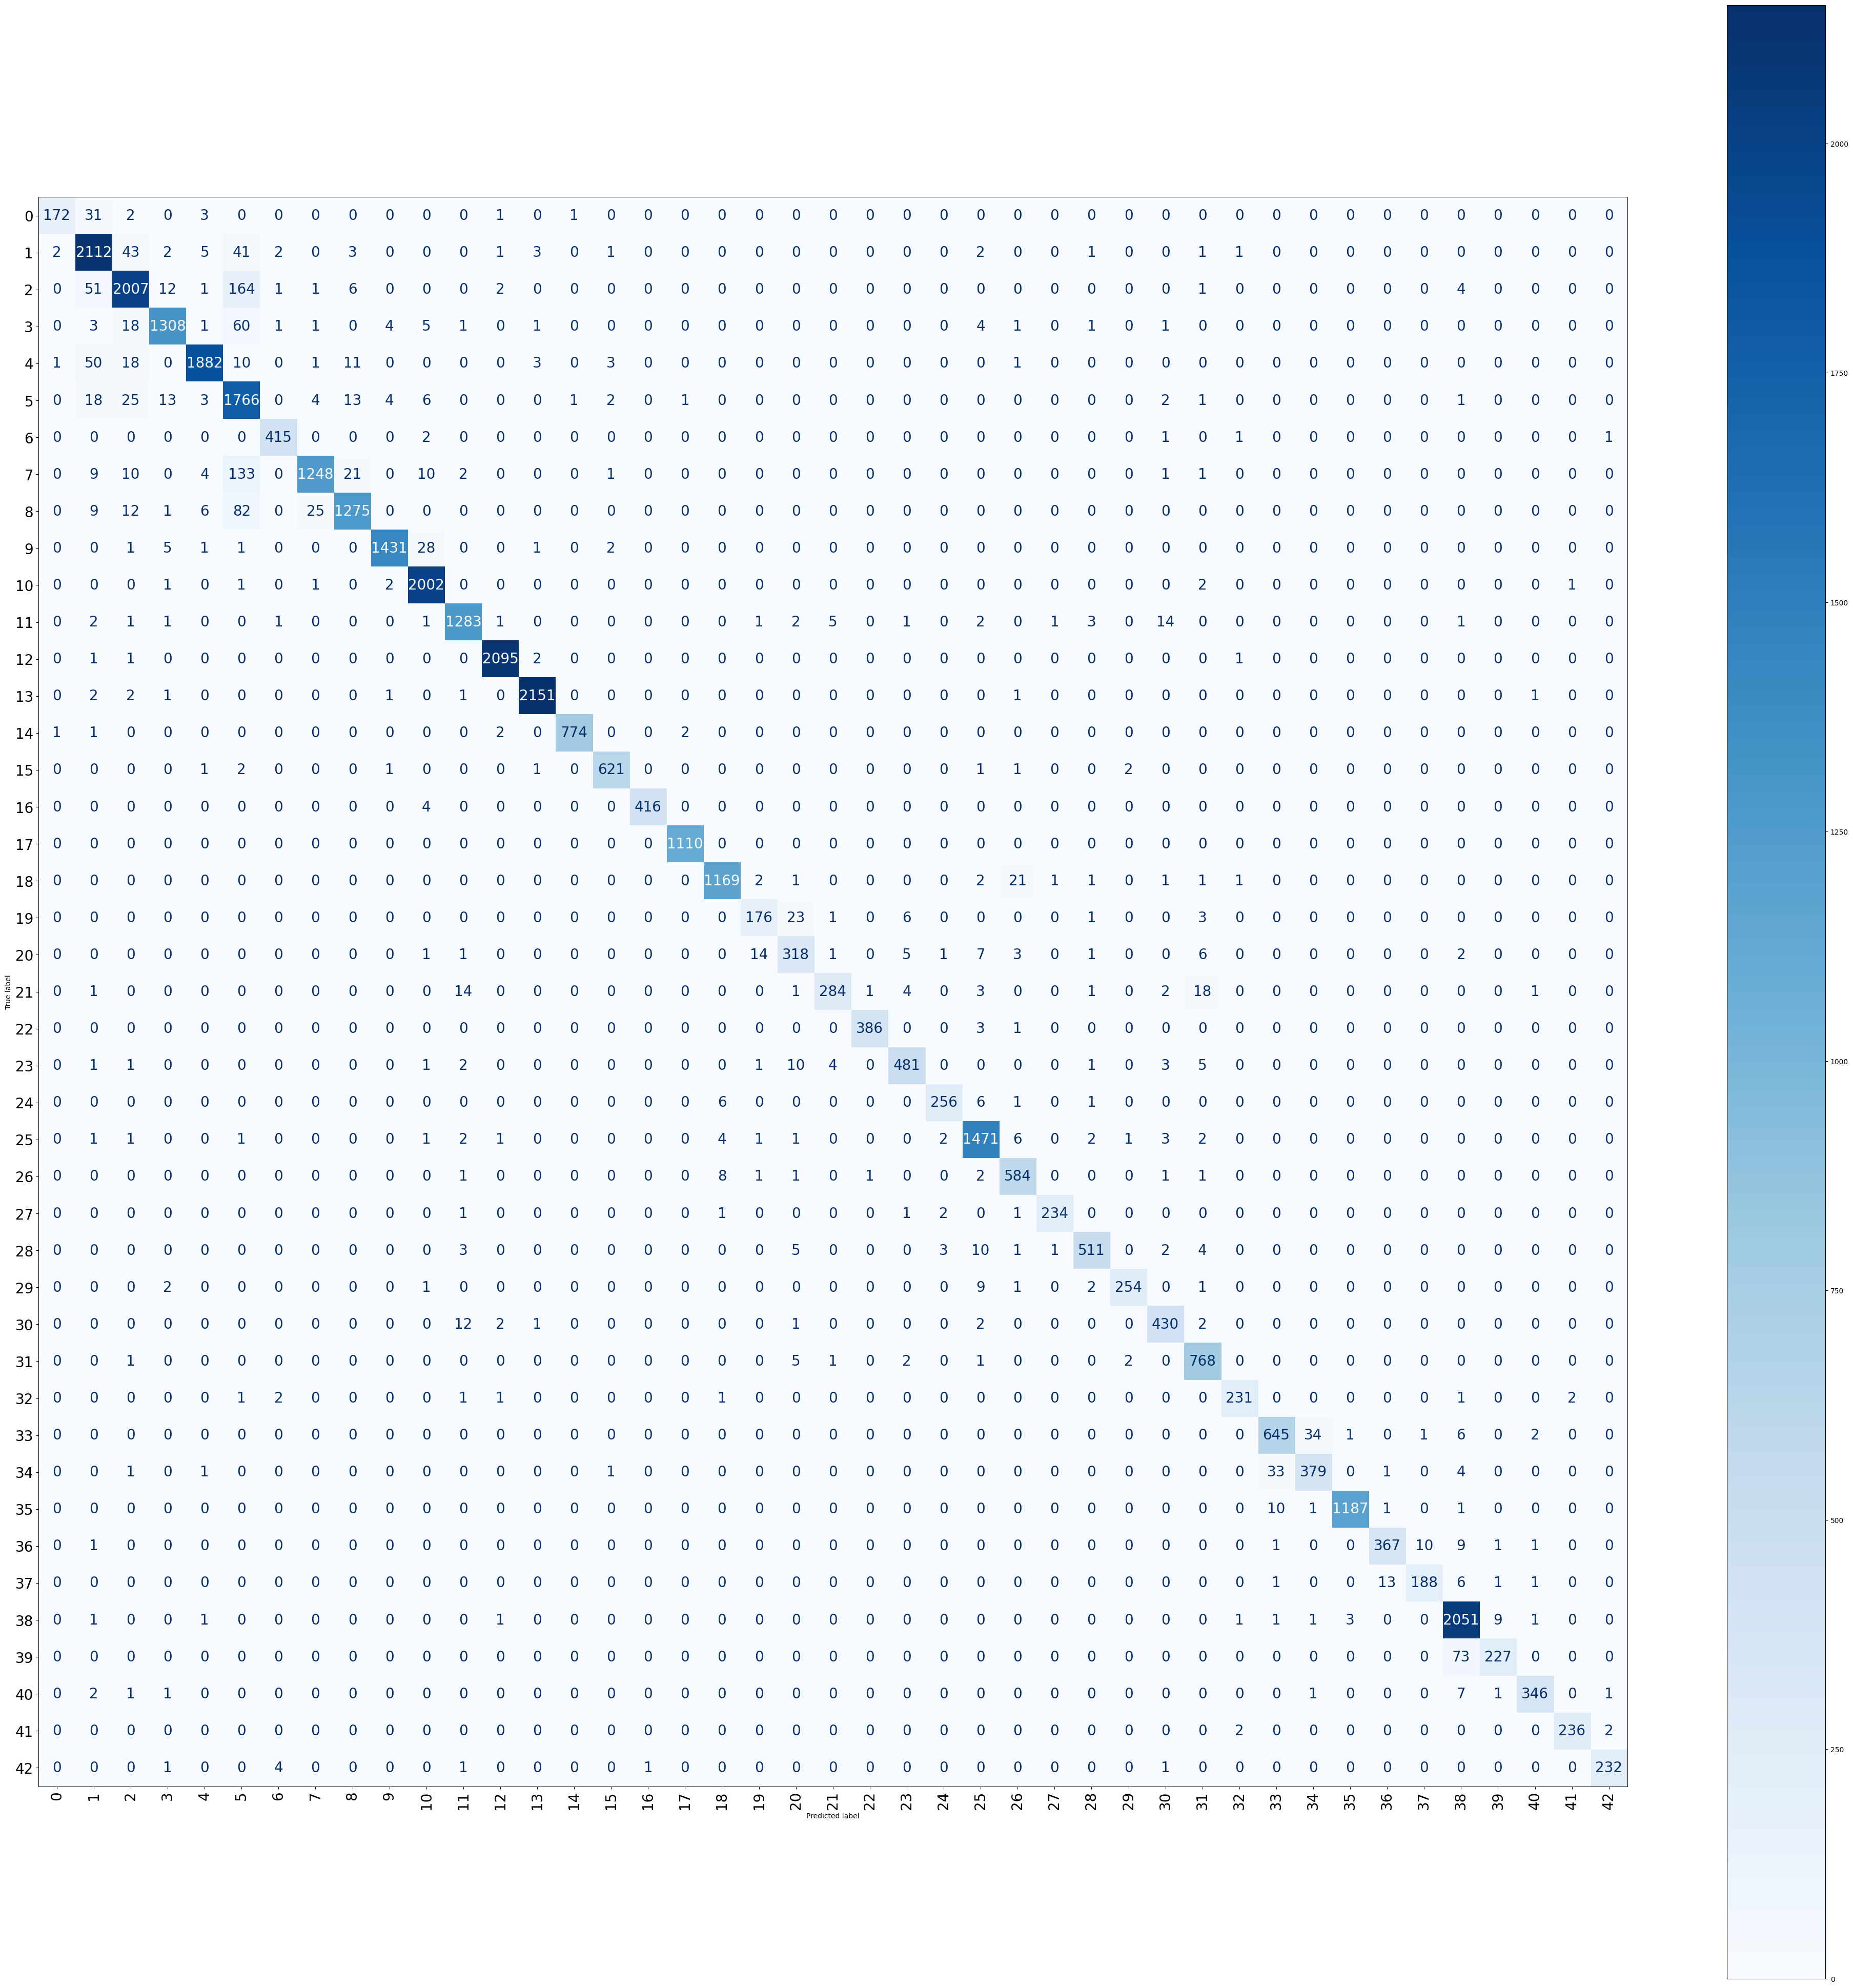

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(50,50))
disp.plot(cmap=plt.cm.Blues,ax=ax, xticks_rotation='vertical')
for text in ax.texts:
    text.set_fontsize(20)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

plt.show()

In [ ]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

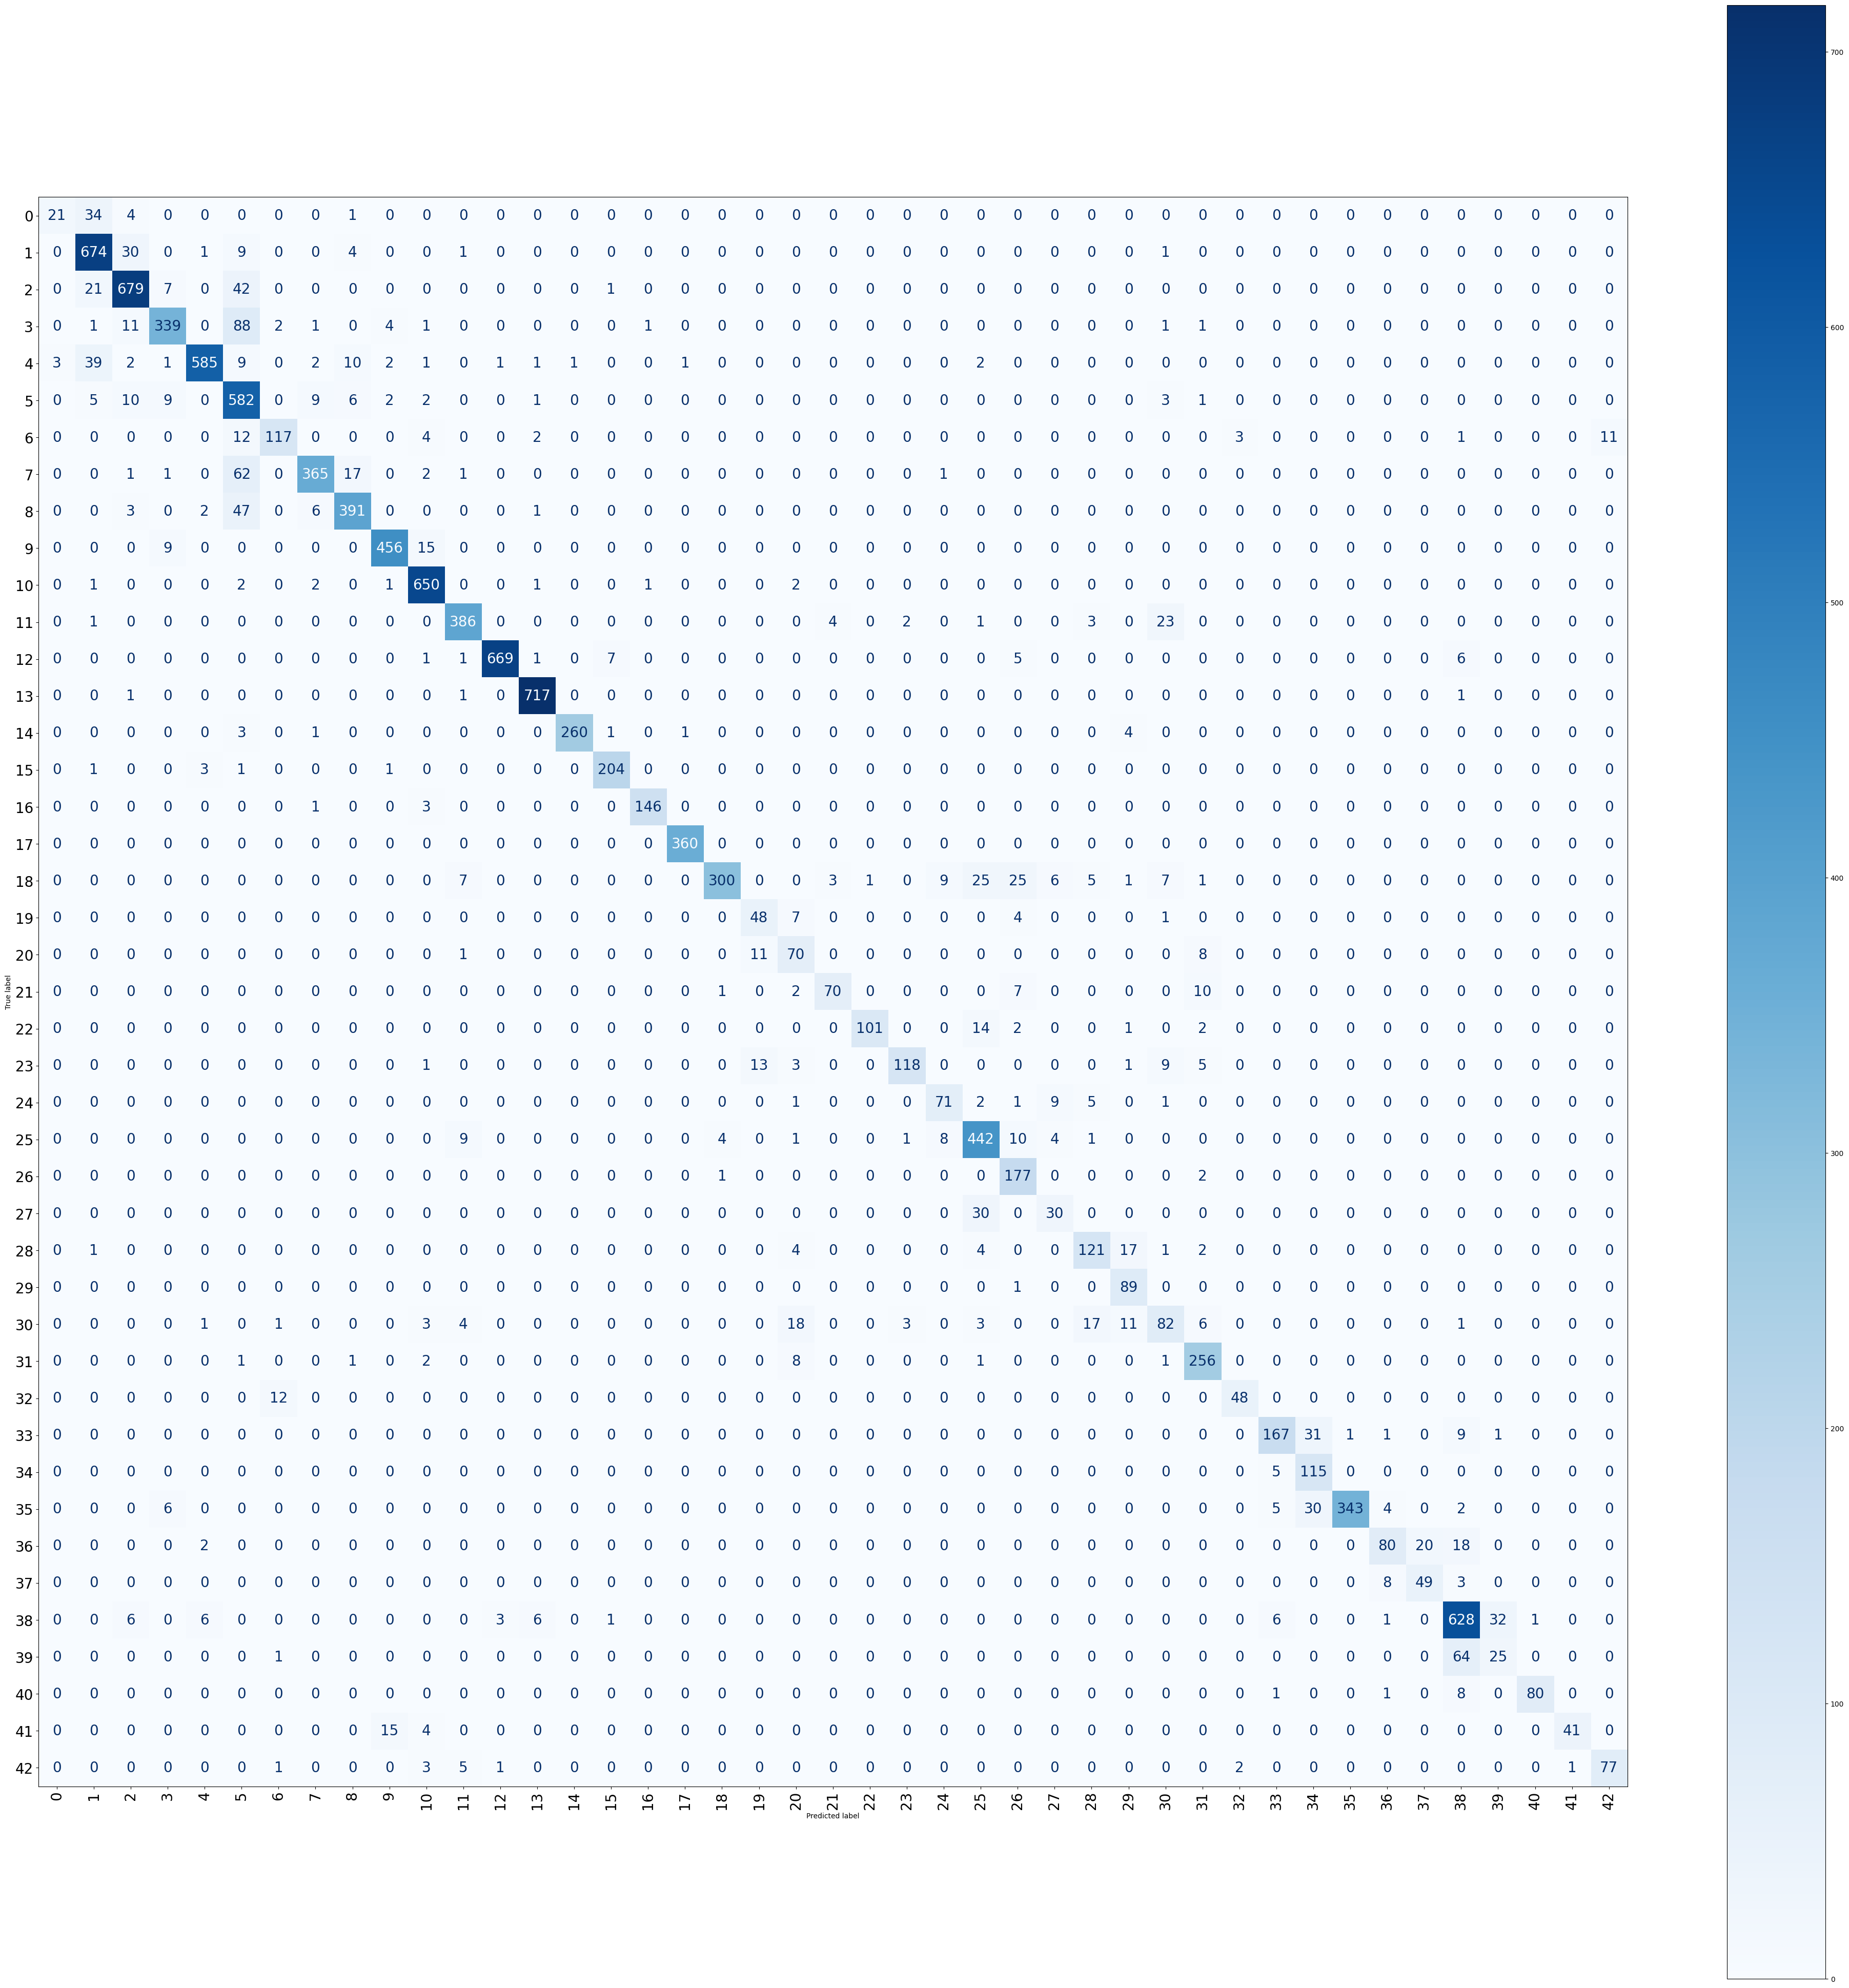

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(50,50))
disp.plot(cmap=plt.cm.Blues,ax=ax, xticks_rotation='vertical')
for text in ax.texts:
    text.set_fontsize(20)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

plt.show()

## Exercises

1. Does training the model for **20 epochs** improve its performance? Summarize your conclusions.  

2. How does reducing the **batch size** from `128` to `64` affect the results?  
   Provide a comparative table including **training time** and **accuracy**.  

3. What happens when you increase the **learning rate**? Does the model improve or degrade? State your conclusions.  

4. How does switching the optimizer from **Adam** to **SGD** impact the model's performance? Summarize your findings.  

